In [3]:
# Checkout www.pygimli.org for more examples


# 2D gravity synthetic modelling and inversion

In the following, we will build the model, create synthetic data, and do
inversion using a depth-weighting function as outlined in the paper.


In [4]:
import numpy as np
import pygimli as pg
import pygimli.meshtools as mt
# from pygimli.viewer import pv
from pygimli.physics.gravimetry import GravityModelling2D

## Synthetic model and data generation
We create a rectangular modelling domain (50x15m) with a flat anomaly  
in a depth of about 5m.




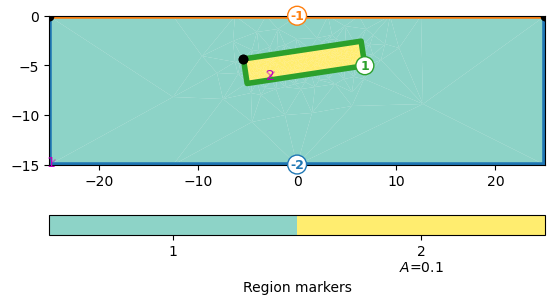

In [5]:
world = mt.createWorld(start=[-25, 0], end=[25, -15],
                       marker=1)
rect = mt.createRectangle(start=[-6, -3.5], end=[6, -6.0],
                          marker=2, area=0.1)
rect.rotate([0, 0, 0.15])

geom = world + rect
pg.show(geom, markers=True)
mesh = mt.createMesh(geom, quality=33, area=0.2)

We assume measuring the gravity on a 50m long profile with dense spacing.
We initialize the forward response by passing mesh and measuring points.
Additionally, we map a density to the cell markers to build a model vector.




In [6]:
x = np.arange(-25, 25.1, .5)
pnts = np.array([x, np.zeros(len(x))]).T

fop = GravityModelling2D(mesh=mesh, points=pnts)
dRho = pg.solver.parseMapToCellArray([[1, 0.0], [2, 300]], mesh)
g = fop.response(dRho)

We define an absolute error and add some Gaussian noise.




In [7]:
error = 0.0005
data = g + np.random.randn(len(g)) * error

The model response is then plotted along with the model




(-25.0, 25.0)

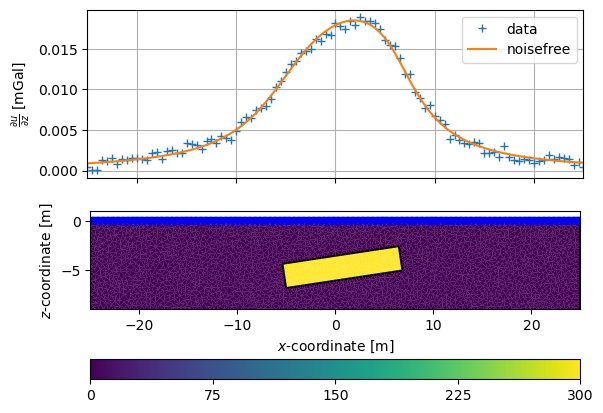

In [8]:
fig, ax = pg.plt.subplots(ncols=1, nrows=2, sharex=True)
ax[0].plot(x, data, "+", label="data")
ax[0].plot(x, g, "-", label="noisefree")
ax[0].set_ylabel(r'$\frac{\partial u}{\partial z}$ [mGal]')
ax[0].grid()
ax[0].legend()

pg.show(mesh, dRho, ax=ax[1])
ax[1].plot(x, x*0, 'bv')
ax[1].set_xlabel('$x$-coordinate [m]')
ax[1].set_ylabel('$z$-coordinate [m]')
ax[1].set_ylim((-9, 1))
ax[1].set_xlim((-25, 25))

For inversion, we create a new mesh from the rectangular domain and setup a
new instance of the modelling operator.




In [9]:
mesh = mt.createMesh(world, quality=33, area=1)
fop = GravityModelling2D(mesh=mesh, points=pnts)

## Depth weighting

In the paper of Li & Oldenburg (1996), they propose a depth weighting of the
constraints with the formula

\begin{align}w_z = \frac{1}{(z+z_0)^{3/2}}\end{align}




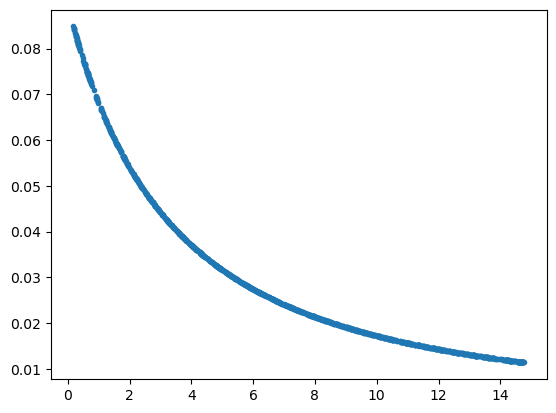

In [10]:
cz = -pg.y(mesh.cellCenters())
z0 = 5
wz = 1 / (cz+z0)**1.5
pg.plt.plot(cz, wz, ".")

## Inversion

For inversion, we use geostatistic regularization with a higher correlation
length for x, compared to y, to account for the large equivalence.
We limit the model to reasonable density contrasts of +/- 1000 kg/m^3.
As the depth weighting decreases the local regularization weights, we have
to increase the overall regularization strength lambda.




In [11]:
fop.region(1).setConstraintType(2)
inv = pg.Inversion(fop=fop)
inv.setRegularization(limits=[-1000, 1000], trans="Cot",
                      correlationLengths=[12, 2])
inv.setConstraintWeights(wz)
rho = inv.run(g, absoluteError=error, lam=1e5, verbose=True)

08/11/23 - 13:26:09 - pyGIMLi - INFO - Use median(data values)=0.0036538891744207695
08/11/23 - 13:26:09 - pyGIMLi - INFO - Created startmodel from forward operator: 1288, min/max=0.003654/0.003654
08/11/23 - 13:26:09 - pyGIMLi - INFO - Starting inversion.
08/11/23 - 13:26:09 - pyGIMLi - INFO - Creating GeostatisticConstraintsMatrix for region 1 with: I=[12, 2], dip=0, strike=0
08/11/23 - 13:26:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
08/11/23 - 13:26:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
08/11/23 - 13:26:09 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 2683 Cells: 5152 Boundaries: 3970


fop: <pygimli.physics.gravimetry.gravMagModelling.GravityModelling2D object at 0x000001F01AA5A7C0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x000001F01AA5E340>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransCotLU object at 0x000001F00E529280>
min/max (data): 8.9e-04/0.02
min/max (error): 2.7%/56.44%
min/max (start model): 0.0037/0.0037
--------------------------------------------------------------------------------


08/11/23 - 13:26:10 - pyGIMLi - INFO - (C) Time for eigenvalue decomposition 1.4s
08/11/23 - 13:26:10 - pyGIMLi - INFO - Cache stored: C:\Users\nieboer\AppData\Roaming\pygimli\Cache\13105230189465013767


--------------------------------------------------------------------------------
inv.iter 1 ... chi² = 0.02 (dPhi = 99.95%) lam: 100000.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.02)                   #
################################################################################


## Visualization

For showing the model, we again plot model response and model.




08/11/23 - 13:26:11 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(-25.0, 25.0)

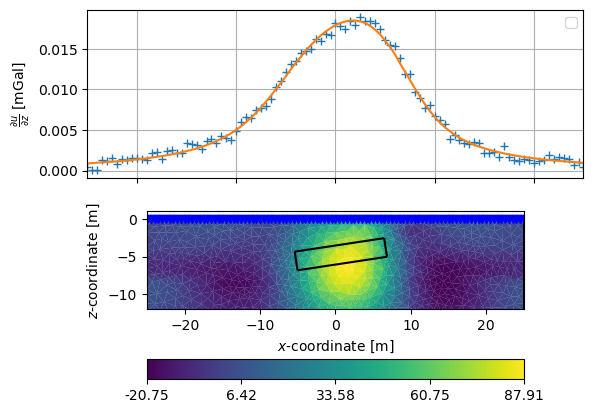

In [12]:
fig, ax = pg.plt.subplots(ncols=1, nrows=2, sharex=True)
ax[0].plot(x, data, "+")
ax[0].plot(x, inv.response, "-")
ax[0].set_ylabel(r'$\frac{\partial u}{\partial z}$ [mGal]')
ax[0].grid()
ax[0].legend()

pg.show(mesh, rho, ax=ax[1], logScale=False)
pg.viewer.mpl.drawPLC(ax[1], rect, fillRegion=False)
ax[1].plot(x, x*0, 'bv')
ax[1].set_xlabel('$x$-coordinate [m]')
ax[1].set_ylabel('$z$-coordinate [m]')
ax[1].set_ylim((-12, 1))
ax[1].set_xlim((-25, 25))

## References

-  Li, Y. & Oldenburg, D. (1996): 3-D inversion of magnetic data.
   Geophysics 61(2), 394-408.
-  Holstein, H., Sherratt, E.M., Reid, A.B.  (2007): Gravimagnetic field
   tensor gradiometry formulas for uniform polyhedra, SEG Ext. Abstr.


